In [1]:
import sys
import os
sys.path.append('../../src/porbnet-sgcp')
import GP
import torch
import matplotlib.pyplot as plt
import numpy as np

save = False

In [2]:
x1 = torch.tensor([1,2,3]).reshape(-1,1).float()
x2 = torch.tensor([4,5]).reshape(-1,1).float()

In [3]:
def cdist(x1, x2):
    # squared euclidean distance, same as scipy.spatial.distance.cdist(x1,x2,'sqeuclidean')
    xx1 = x1.unsqueeze(1).expand(x1.shape[0],x2.shape[0],x1.shape[1])
    xx2 = x2.unsqueeze(0).expand(x1.shape[0],x2.shape[0],x2.shape[1])
    return torch.pow(xx1 - xx2,2).sum(2)

In [4]:
class NonstationaryKernel:
    def __init__(self, length_scale, variance):
        self.length_scale = length_scale
        self.variance = variance

    def __call__(self, x1, x2=None):
        if x2 is None:
            x2 = x1
            
        dist = cdist(x1, x2)
            
        l1 = self.length_scale(x1)
        l2 = self.length_scale(x2)
        
        l1_times_l2 = l1.reshape(-1,1) @ l2.reshape(1,-1)
        l1_plus_l2 = l1.pow(2).reshape(-1,1) + l2.pow(2).reshape(1,-1)
        
        s1 = self.variance(x1)
        s2 = self.variance(x2)

        s1_times_s2 = s1.reshape(-1,1) @ s2.reshape(1,-1)
        
        return s1_times_s2 * \
            torch.sqrt(2*l1_times_l2 /  l1_plus_l2) * \
            torch.exp(-dist / l1_plus_l2)

In [5]:
def sample_dataset(gp, n_train=100, n_val=50, n_test=50, x_min=-5, x_max=5, sig2=.01, 
                  seed_x=0, seed_f=1, seed_y=3):
    # Single dataset
    x_plot = torch.linspace(x_min,x_max,100).reshape(-1,1)

    n = n_train + n_val + n_test 
    
    torch.manual_seed(seed_x)
    x = torch.FloatTensor(n, 1).uniform_(x_min, x_max)
    x_all = torch.cat((x, x_plot))
    
    torch.manual_seed(seed_f)
    np.random.seed(seed_f) # possible numpy used
    f_all = gp.sample_y(x_all)
    f = f_all[:n]
    f_plot = f_all[n:]
    
    torch.manual_seed(seed_y)
    y = f + torch.sqrt(torch.tensor(sig2))*torch.randn(f.shape)

    idx = torch.randperm(n)
    idx_train = idx[:n_train]
    idx_val = idx[n_train:n_train+n_val]
    idx_test = idx[n_train+n_val:n_train+n_val+n_test]

    x_train = x[idx_train]
    x_val = x[idx_val]
    x_test = x[idx_test]

    y_train = y[idx_train]
    y_val = y[idx_val]
    y_test = y[idx_test]
    
    return x_train, y_train, x_val, y_val, x_test, y_test, x_plot, f_plot

def sample_dataset_gaps(gp, n_total=100, frac_train=.75, gaps=[(-2,-1),(1,2)], x_min=-5, x_max=5, sig2=.01, \
                       seed_x=0, seed_f=1, seed_y=3):
    # Single dataset
    x_plot = torch.linspace(x_min,x_max,100).reshape(-1,1)

    n = n_total
    
    torch.manual_seed(seed_x)
    x = torch.FloatTensor(n, 1).uniform_(x_min, x_max)
    x_all = torch.cat((x, x_plot))
    
    torch.manual_seed(seed_f)
    np.random.seed(seed_f) # possible numpy used
    f_all = gp.sample_y(x_all)
    f = f_all[:n]
    f_plot = f_all[n:]
    
    torch.manual_seed(seed_y)
    y = f + torch.sqrt(torch.tensor(sig2))*torch.randn(f.shape)

    idx_test = torch.zeros(x.shape[0], dtype=torch.uint8)
    for (lb, ub) in gaps:
        idx_test = idx_test | ((x>= torch.tensor(lb).float()).view(-1) & (x<= torch.tensor(ub).float()).view(-1))
    
    idx_train_val = (~idx_test).nonzero().reshape(-1)
    n_train_val = idx_train_val.shape[0]
    n_train = int(frac_train * n_train_val)
    n_val = n_train_val - n_train

    idx = torch.randperm(n_train_val)
    idx_train = idx_train_val[idx[:n_train]]
    idx_val = idx_train_val[idx[n_train:]]

    x_train = x[idx_train]
    x_val = x[idx_val]
    x_test = x[idx_test]

    y_train = y[idx_train]
    y_val = y[idx_val]
    y_test = y[idx_test]
    
    return x_train, y_train, x_val, y_val, x_test, y_test, x_plot, f_plot

def save_data(fname, x_train, y_train, x_val, y_val, x_test, y_test, x_plot, f_plot):
    if not os.path.exists(fname):
        os.makedirs(fname)
    np.savetxt(os.path.join(fname,'x_train.csv'), x_train.numpy())
    np.savetxt(os.path.join(fname,'y_train.csv'), y_train.numpy())
    np.savetxt(os.path.join(fname,'x_val.csv'), x_val.numpy())
    np.savetxt(os.path.join(fname,'y_val.csv'), y_val.numpy())
    np.savetxt(os.path.join(fname,'x_test.csv'), x_test.numpy())
    np.savetxt(os.path.join(fname,'y_test.csv'), y_test.numpy())
    np.savetxt(os.path.join(fname,'x_plot.csv'), x_plot.numpy())
    np.savetxt(os.path.join(fname,'f_plot.csv'), f_plot.numpy())
    

In [6]:
x_plot = torch.linspace(-5,5,100).reshape(-1,1)

## Stationary function

In [10]:
length_scale = lambda z: torch.sin(z) + 1.1
variance = lambda z: torch.ones_like(z).float()

k = GP.RBFkernel(length_scale=1, variance=1)
gp = GP.GP(k)

#### Uniform sampling

error with mvn, trying numpy version


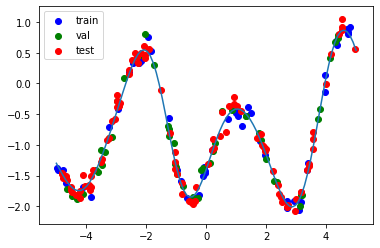

In [11]:
x_train, y_train, x_val, y_val, x_test, y_test, x_plot, f_plot = \
    sample_dataset(gp, n_train=50, n_val=50, n_test=100, x_min=-5, x_max=5, sig2=.01, \
                  seed_x=0, seed_f=1, seed_y=3)

fig, ax = plt.subplots(1,1)
ax.plot(x_plot.numpy(), f_plot.numpy())
ax.scatter(x_train, y_train, color='b', label='train')
ax.scatter(x_val, y_val, color='g', label='val')
ax.scatter(x_test, y_test, color='r', label='test')
ax.legend()


In [12]:
xbias = x_train.min()
xscale = x_train.max()-x_train.min()

print('xbias', xbias)
print('xscale', xscale)

xbias tensor(-4.9876)
xscale tensor(9.7886)


In [49]:
if save:
    save_data('stat/', x_train.reshape(-1,1), y_train.reshape(-1,1), \
              x_val.reshape(-1,1), y_val.reshape(-1,1), \
              x_test.reshape(-1,1), y_test.reshape(-1,1), \
              x_plot.reshape(-1,1), f_plot.reshape(-1,1))


#### Gaps

error with mvn, trying numpy version
n_train: 150


../aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
../aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.


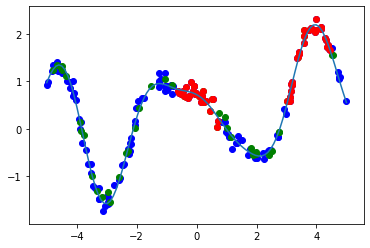

In [15]:
x_train, y_train, x_val, y_val, x_test, y_test, x_plot, f_plot = \
    sample_dataset_gaps(gp, n_total=200, frac_train=.75, gaps=[(-0.75,0.75),(3,4.5)], x_min=-5, x_max=5, sig2=.01, \
                  seed_x=0, seed_f=6, seed_y=3)

fig, ax = plt.subplots(1,1)
ax.plot(x_plot.numpy(), f_plot.numpy())
ax.scatter(x_train, y_train, color='b', label='train')
ax.scatter(x_val, y_val, color='g', label='val')
ax.scatter(x_test, y_test, color='r', label='test')

print('n_train:', x_train.shape[0])


In [16]:
print('xbias', xbias)
print('xscale', xscale)

xbias tensor(-4.9876)
xscale tensor(9.7886)


In [51]:
if save:
    save_data('stat_gap/', x_train.reshape(-1,1), y_train.reshape(-1,1), \
              x_val.reshape(-1,1), y_val.reshape(-1,1), \
              x_test.reshape(-1,1), y_test.reshape(-1,1), \
              x_plot.reshape(-1,1), f_plot.reshape(-1,1))

## Sine wave lengthscale

In [147]:
length_scale = lambda z: torch.sin(z) + 1.1
variance = lambda z: torch.ones_like(z).float()

k = NonstationaryKernel(length_scale, variance)

gp = GP.GP(k)

Text(0.5, 1.0, 'lengthscale')

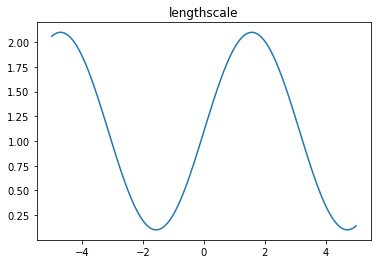

In [148]:
plt.plot(x_plot.reshape(-1).numpy(), length_scale(x_plot).reshape(-1).numpy())
plt.title('lengthscale')

error with mvn, trying numpy version
error with mvn, trying numpy version
error with mvn, trying numpy version
error with mvn, trying numpy version
error with mvn, trying numpy version
error with mvn, trying numpy version
error with mvn, trying numpy version
error with mvn, trying numpy version
error with mvn, trying numpy version
error with mvn, trying numpy version
error with mvn, trying numpy version
error with mvn, trying numpy version
error with mvn, trying numpy version
error with mvn, trying numpy version
error with mvn, trying numpy version
error with mvn, trying numpy version
error with mvn, trying numpy version
error with mvn, trying numpy version
error with mvn, trying numpy version
error with mvn, trying numpy version
error with mvn, trying numpy version
error with mvn, trying numpy version
error with mvn, trying numpy version
error with mvn, trying numpy version
error with mvn, trying numpy version
error with mvn, trying numpy version
error with mvn, trying numpy version
e

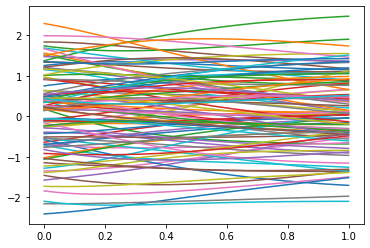

In [143]:
nsamp = 100

Y = torch.zeros(nsamp, x_plot.shape[0])
for samp in range(nsamp):
    Y[samp,:] = gp.sample_y(x_plot).reshape(-1)

_=plt.plot(x_plot.reshape(-1).numpy(), Y.numpy().T)

error with mvn, trying numpy version


Text(0, 0.5, 'lengthscale')

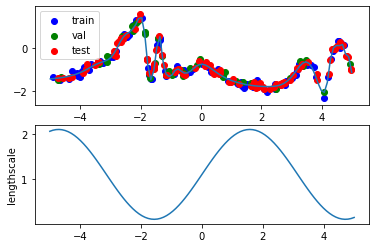

In [149]:
x_train, y_train, x_val, y_val, x_test, y_test, x_plot, f_plot = \
    sample_dataset(gp, n_train=100, n_val=50, n_test=100, x_min=-5, x_max=5, sig2=.01, \
                  seed_x=6, seed_f=3, seed_y=3)

fig, ax = plt.subplots(2,1)
ax[0].plot(x_plot.numpy(), f_plot.numpy())
ax[0].scatter(x_train, y_train, color='b', label='train')
ax[0].scatter(x_val, y_val, color='g', label='val')
ax[0].scatter(x_test, y_test, color='r', label='test')
ax[0].legend()

ax[1].plot(x_plot.reshape(-1).numpy(), length_scale(x_plot).reshape(-1).numpy())
ax[1].set_ylabel('lengthscale')

In [9]:
def standardize(x, y, x_test=None, y_test=None):
    # rescale
    xbias = x.min()
    xscale = x.max()-x.min()
    yscale = (np.abs(y-y.mean())).max()
    ybias = y.mean()
    x = (x - xbias) / xscale
    y = (y - ybias) / yscale
    
    print('xbias', xbias)
    print('xscale', xscale)

    if x_test is not None and y_test is not None:
        x_test = (x_test - xbias) / xscale
        y_test = (y_test - ybias) / yscale
        return x, y, x_test, y_test
    else:
        return x, y

In [44]:
x_train2, y_train2, x_test2, y_test2 = standardize(x_train, y_train, x_test, y_test)

_, _, x_plot2, f_plot2 = standardize(x_train, y_train, x_plot, f_plot)


In [150]:
xbias = x_train.min()
xscale = x_train.max()-x_train.min()

yscale = (np.abs(y_train-y_train.mean())).max()
ybias = y_train.mean()

l_plot = length_scale(x_plot)

#_, _, _, l_plot2 = standardize(x_train, y_train, x_plot, l_plot)
l_plot2 = (l_plot - ybias) / yscale

In [61]:
ybias

tensor(-0.7636)

In [62]:
yscale

tensor(2.1635)

In [56]:
length_scale2 = lambda z: (torch.sin(z) + 1.1 - ybias) / yscale

Text(0, 0.5, 'lengthscale')

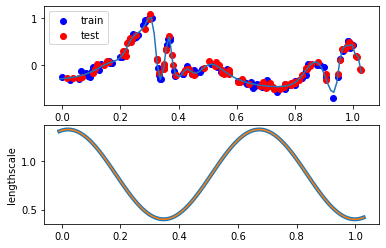

In [60]:
fig, ax = plt.subplots(2,1)
ax[0].plot(x_plot2.numpy(), f_plot2.numpy())
ax[0].scatter(x_train2, y_train2, color='b', label='train')

ax[0].scatter(x_test2, y_test2, color='r', label='test')
ax[0].legend()


ax[1].plot(x_plot2.reshape(-1).numpy(), length_scale2(x_plot).reshape(-1).numpy(),linewidth=4)
ax[1].plot(x_plot2.reshape(-1).numpy(), l_plot2.reshape(-1).numpy())

ax[1].set_ylabel('lengthscale')

In [83]:
torch.linspace(0,1,100).reshape(-1,1)*xscale + xbias;

In [136]:
length_scale_orig = lambda z: np.sin(z) + 1.1
length_scale = lambda z: (length_scale_orig(z*xscale + xbias) - ybias) / yscale

length_scale = lambda z: length_scale_orig(z*xscale + xbias) / xscale



In [151]:
xscale

tensor(9.6491)

In [152]:
xbias

tensor(-4.9189)

In [137]:
variance = lambda z: torch.ones_like(z).float() / yscale

k = NonstationaryKernel(length_scale, variance)

gp = GP.GP(k)


error with mvn, trying numpy version


/Users/beaucoker/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Text(0, 0.5, 'lengthscale')

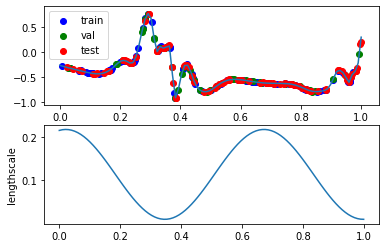

In [138]:
x_train, y_train, x_val, y_val, x_test, y_test, x_plot, f_plot = \
    sample_dataset(gp, n_train=100, n_val=50, n_test=100, x_min=0, x_max=1, sig2=.0001/yscale**2, \
                  seed_x=6, seed_f=3, seed_y=3)

fig, ax = plt.subplots(2,1)
ax[0].plot(x_plot.numpy(), f_plot.numpy())
ax[0].scatter(x_train, y_train, color='b', label='train')
ax[0].scatter(x_val, y_val, color='g', label='val')
ax[0].scatter(x_test, y_test, color='r', label='test')
ax[0].legend()

ax[1].plot(x_plot.reshape(-1).numpy(), length_scale(x_plot).reshape(-1).numpy())
ax[1].set_ylabel('lengthscale')

In [56]:
#if save:
#    save_data('sin/', x_train.reshape(-1,1), y_train.reshape(-1,1), \
#              x_val.reshape(-1,1), y_val.reshape(-1,1), \
#              x_test.reshape(-1,1), y_test.reshape(-1,1), \
#              x_plot.reshape(-1,1), f_plot.reshape(-1,1))

## Step lengthscale

In [57]:
def length_scale(z, ls_low=.25, ls_high=2.):
    ls = torch.zeros_like(z).float()
    ls[z>=0] = ls_high
    ls[z<0] = ls_low
    return ls

variance = lambda z: torch.ones_like(z).float()

k = NonstationaryKernel(length_scale, variance)
k(x1, x2)

gp = GP.GP(k)

#### Unform sampling

error with mvn, trying numpy version


Text(0, 0.5, 'lengthscale')

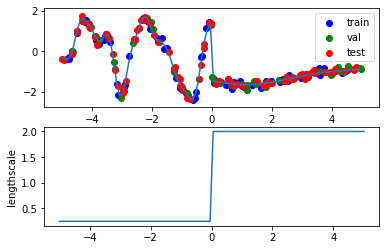

In [58]:
x_train, y_train, x_val, y_val, x_test, y_test, x_plot, f_plot = \
    sample_dataset(gp, n_train=100, n_val=50, n_test=100, x_min=-5, x_max=5, sig2=.01, \
                  seed_x=0, seed_f=1, seed_y=3)

fig, ax = plt.subplots(2,1)
ax[0].plot(x_plot.numpy(), f_plot.numpy())
ax[0].scatter(x_train, y_train, color='b', label='train')
ax[0].scatter(x_val, y_val, color='g', label='val')
ax[0].scatter(x_test, y_test, color='r', label='test')
ax[0].legend()

ax[1].plot(x_plot.reshape(-1).numpy(), length_scale(x_plot).reshape(-1).numpy())
ax[1].set_ylabel('lengthscale')

In [59]:
if save:
    save_data('step/', x_train.reshape(-1,1), y_train.reshape(-1,1), \
              x_val.reshape(-1,1), y_val.reshape(-1,1), \
              x_test.reshape(-1,1), y_test.reshape(-1,1), \
              x_plot.reshape(-1,1), f_plot.reshape(-1,1))

#### Gaps

error with mvn, trying numpy version
n_train: 105


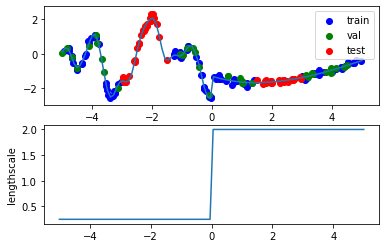

In [60]:
x_train, y_train, x_val, y_val, x_test, y_test, x_plot, f_plot = \
    sample_dataset_gaps(gp, n_total=200, frac_train=.75, gaps=[(-3,-1.5),(1.5,3)], x_min=-5, x_max=5, sig2=.01, \
                  seed_x=0, seed_f=1, seed_y=3)

fig, ax = plt.subplots(2,1)
ax[0].plot(x_plot.numpy(), f_plot.numpy())
ax[0].scatter(x_train, y_train, color='b', label='train')
ax[0].scatter(x_val, y_val, color='g', label='val')
ax[0].scatter(x_test, y_test, color='r', label='test')
ax[0].legend()

ax[1].plot(x_plot.reshape(-1).numpy(), length_scale(x_plot).reshape(-1).numpy())
ax[1].set_ylabel('lengthscale')

print('n_train:', x_train.shape[0])


In [61]:
if save:
    save_data('step_gap/', x_train.reshape(-1,1), y_train.reshape(-1,1), \
              x_val.reshape(-1,1), y_val.reshape(-1,1), \
              x_test.reshape(-1,1), y_test.reshape(-1,1), \
              x_plot.reshape(-1,1), f_plot.reshape(-1,1))

## Increasing lengthscale

In [17]:
def length_scale(x, ls_min=.25, ls_max=2, x_min=-5, x_max=5):
    slope = (ls_max - ls_min) / (x_max - x_min) 
    ls = (x - x_min)*slope + ls_min
    return ls**2

variance = lambda z: torch.ones_like(z).float()

k = NonstationaryKernel(length_scale, variance)
k(x1, x2)

gp = GP.GP(k)

#### Uniform sampling

error with mvn, trying numpy version


Text(0, 0.5, 'lengthscale')

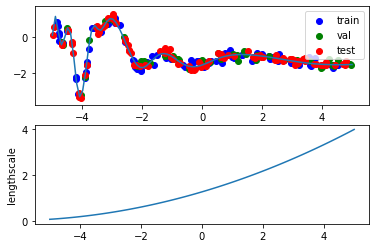

In [18]:
x_train, y_train, x_val, y_val, x_test, y_test, x_plot, f_plot = \
    sample_dataset(gp, n_train=100, n_val=50, n_test=100, x_min=-5, x_max=5, sig2=.02, \
                  seed_x=0, seed_f=1, seed_y=3)

fig, ax = plt.subplots(2,1)
ax[0].plot(x_plot.numpy(), f_plot.numpy())
ax[0].scatter(x_train, y_train, color='b', label='train')
ax[0].scatter(x_val, y_val, color='g', label='val')
ax[0].scatter(x_test, y_test, color='r', label='test')
ax[0].legend()

ax[1].plot(x_plot.reshape(-1).numpy(), length_scale(x_plot).reshape(-1).numpy())
ax[1].set_ylabel('lengthscale')

In [20]:
print('xbias', xbias)
print('xscale', xscale)

xbias tensor(-4.9876)
xscale tensor(9.7886)


In [64]:
if save:
    save_data('inc/', x_train.reshape(-1,1), y_train.reshape(-1,1), \
              x_val.reshape(-1,1), y_val.reshape(-1,1), \
              x_test.reshape(-1,1), y_test.reshape(-1,1), \
              x_plot.reshape(-1,1), f_plot.reshape(-1,1))

#### Gaps

error with mvn, trying numpy version


../aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
../aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.


Text(0, 0.5, 'lengthscale')

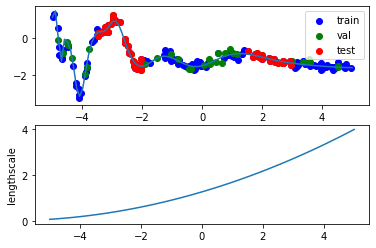

In [21]:
x_train, y_train, x_val, y_val, x_test, y_test, x_plot, f_plot = \
    sample_dataset_gaps(gp, n_total=200, frac_train=.75, gaps=[(-3.5,-2),(1.5,3)], x_min=-5, x_max=5, sig2=.02, \
                  seed_x=0, seed_f=1, seed_y=3)

fig, ax = plt.subplots(2,1)
ax[0].plot(x_plot.numpy(), f_plot.numpy())
ax[0].scatter(x_train, y_train, color='b', label='train')
ax[0].scatter(x_val, y_val, color='g', label='val')
ax[0].scatter(x_test, y_test, color='r', label='test')
ax[0].legend()

ax[1].plot(x_plot.reshape(-1).numpy(), length_scale(x_plot).reshape(-1).numpy())
ax[1].set_ylabel('lengthscale')

In [23]:
print('xbias', xbias)
print('xscale', xscale)

xbias tensor(-4.9876)
xscale tensor(9.7886)


In [66]:
if save:
    save_data('inc_gap/', x_train.reshape(-1,1), y_train.reshape(-1,1), \
              x_val.reshape(-1,1), y_val.reshape(-1,1), \
              x_test.reshape(-1,1), y_test.reshape(-1,1), \
              x_plot.reshape(-1,1), f_plot.reshape(-1,1))